In [1]:
!nvidia-smi

Tue Oct  1 14:39:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf

print('built with cuda',tf.test.is_built_with_cuda(), '\n',
'gpus available',tf.test.is_gpu_available())

gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')

built with cuda True 
 gpus available True


In [3]:
import re
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
import glob
import json
import requests
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid")

import tf_keras
from tf_keras.models import Sequential, Model, save_model, load_model
from tf_keras.layers import (Dense, Dropout, Activation, MaxPool2D, Flatten, Conv2D, UpSampling2D, Input,
                             Conv2DTranspose, LeakyReLU, BatchNormalization, Reshape,Input)
from tf_keras.optimizers import Adam, RMSprop
from tf_keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tf_keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tf_keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tf_keras.utils import to_categorical
from tf_keras.preprocessing.image import img_to_array, load_img
from tf_keras.activations import relu, sigmoid, tanh, softmax

import cv2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# import cudf
# from cuml.ensemble import RandomForestClassifier
# from cuml.svm import SVC
# from cuml.multiclass import MulticlassClassifier

In [4]:
image_xlsx_data = r'/kaggle/input/imagedataset/brest-lesion-dataset.xlsx'
norm_image_folder=r'/kaggle/input/imagedataset/norm_grayscale_folder-20241001T052404Z-001/norm_grayscale_folder'
tumor_image_folder = r'/kaggle/input/imagedataset/new_tumor_folder-20241001T052347Z-001/new_tumor_folder'
csv_data = pd.read_excel(image_xlsx_data)
len(os.listdir(norm_image_folder)), len(os.listdir(tumor_image_folder))

(256, 252)

In [5]:
CAE_model = load_model("/kaggle/input/models/autoencoder_model.h5")
SegNet_model = load_model("/kaggle/input/models/segnet_model.h5")

In [6]:
csv_data.head()

,Image_filename,Mask_tumor_filename,thermogramImages,roiImages,normal_image_path,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,Margin,Echogenicity,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,Verification,Diagnosis,BIRADS,Classification
0,case001.png,case001_tumor.png,thermogram_case001.png,output_thermogram_case001.png,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...,0.007812,57,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,not circumscribed - indistinct,heterogeneous,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),confirmed by follow-up care,not applicable,2.0,benign
1,case002.png,case002_tumor.png,thermogram_case002.png,output_thermogram_case002.png,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...,0.006462,53,homogeneous: fat,not available,not available,oval,not circumscribed - indistinct,hypoechoic,no,no,no,no,Dysplasia&Fibroadenoma,confirmed by biopsy,Intramammary lymph node,4.2,benign
2,case003.png,case003_tumor.png,thermogram_case003.png,output_thermogram_case003.png,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...,0.006944,56,heterogeneous: predominantly fat,no,nipple discharge,oval,circumscribed,hyperechoic,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,4.1,benign
3,case004.png,case004_tumor.png,thermogram_case004.png,output_thermogram_case004.png,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...,0.007812,43,homogeneous: fibroglandular,no,no,round,circumscribed,hypoechoic,no,no,no,no,Cyst filled with thick fluid,confirmed by follow-up care,not applicable,3.0,benign
4,case005.png,case005_tumor.png,thermogram_case005.png,output_thermogram_case005.png,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...,0.007812,67,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,circumscribed,complex cystic/solid,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,4.2,malignant


In [7]:
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Image_filename       256 non-null    object 
 1   Mask_tumor_filename  256 non-null    object 
 2   thermogramImages     256 non-null    object 
 3   roiImages            256 non-null    object 
 4   normal_image_path    256 non-null    object 
 5   Pixel_size           256 non-null    float64
 6   Age                  256 non-null    int64  
 7   Tissue_composition   256 non-null    object 
 8   Signs                256 non-null    object 
 9   Symptoms             256 non-null    object 
 10  Shape                256 non-null    object 
 11  Margin               256 non-null    object 
 12  Echogenicity         256 non-null    object 
 13  Posterior_features   256 non-null    object 
 14  Halo                 256 non-null    object 
 15  Calcifications       256 non-null    obj

In [8]:
csv_data.columns

Index(['Image_filename', 'Mask_tumor_filename', 'thermogramImages',
       'roiImages', 'normal_image_path', 'Pixel_size', 'Age',
       'Tissue_composition', 'Signs', 'Symptoms', 'Shape', 'Margin',
       'Echogenicity', 'Posterior_features', 'Halo', 'Calcifications',
       'Skin_thickening', 'Interpretation', 'Verification', 'Diagnosis',
       'BIRADS', 'Classification'],
      dtype='object')

In [9]:
# csv_data.drop(columns=['Image_filename', 'Mask_tumor_filename', 'thermogramImages', 'roiImages', 'normal_image_path'], axis=1, inplace=True)

In [10]:
images = []

for img_name in sorted(os.listdir(norm_image_folder)):
    img_path = os.path.join(norm_image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    images.append(img)

In [11]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNEL = 1
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNEL)

In [12]:
images = np.array(images)
images = images.reshape(-1, IMG_HEIGHT, IMG_WIDTH, CHANNEL)
images.shape

(256, 224, 224, 1)

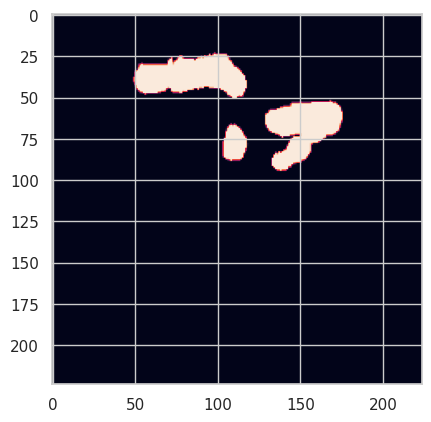

In [13]:
main_mask_path = tumor_image_folder + "/case140_tumor.png"
img = cv2.imread(main_mask_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

In [14]:
mask_paths = []
filtered_image_paths = []
for index, row in csv_data.iterrows():
    if row['Classification'] in ['benign', 'malignant']:
        image_name = row['Mask_tumor_filename']
        masks_for_image = [os.path.join(tumor_image_folder, mask_name) for mask_name in os.listdir(tumor_image_folder) if mask_name.startswith(image_name)]

    if masks_for_image:
        mask_paths.append(masks_for_image)
        filtered_image_paths.append(os.path.join(norm_image_folder,row['Image_filename']))

In [15]:
len(mask_paths), len(filtered_image_paths)

(256, 256)

In [16]:
mask_paths[0], filtered_image_paths[0]

(['/kaggle/input/imagedataset/new_tumor_folder-20241001T052347Z-001/new_tumor_folder/case001_tumor.png'],
 '/kaggle/input/imagedataset/norm_grayscale_folder-20241001T052404Z-001/norm_grayscale_folder/case001.png')

**CAE model prediction**

In [17]:
CAE_features = CAE_model.predict(images)
CAE_features

8/8 [==============================] - 19s 66ms/step


array([[[[-0.11631551],
         [-0.30511102],
         [-0.31902292],
         ...,
         [-0.30131352],
         [-0.3188493 ],
         [-0.46602434]],

        [[ 0.1153986 ],
         [ 0.24907134],
         [ 0.27866068],
         ...,
         [ 0.2520042 ],
         [ 0.28078628],
         [ 0.11488918]],

        [[ 0.11717696],
         [ 0.27246636],
         [ 0.27828503],
         ...,
         [ 0.2760563 ],
         [ 0.28374067],
         [ 0.11534365]],

        ...,

        [[ 0.11024272],
         [ 0.25425237],
         [ 0.27605692],
         ...,
         [ 0.2676114 ],
         [ 0.26940084],
         [ 0.12461945]],

        [[ 0.11730308],
         [ 0.27268082],
         [ 0.28535715],
         ...,
         [ 0.276729  ],
         [ 0.28995985],
         [ 0.11225493]],

        [[ 0.24064037],
         [ 0.39193246],
         [ 0.40041   ],
         ...,
         [ 0.38870004],
         [ 0.40088856],
         [ 0.22328563]]],


       [[[-0.11634541],


In [18]:
CAE_features.shape

(256, 224, 224, 1)

In [19]:
masks = []
for mask_name in filtered_image_paths:
    mask_path = os.path.join(tumor_image_folder, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = mask / 255
    masks.append(mask)

In [20]:
masks_array = np.array(masks)
masks_array = masks_array.reshape(-1, IMG_HEIGHT, IMG_WIDTH, CHANNEL)
masks_array.shape

(256, 224, 224, 1)

In [21]:
mask_paths = [filename for sublist in mask_paths for filename in sublist]

In [22]:
tumor_masks = []
for mask in mask_paths:
    tumor_mask_path = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    tumor_mask_path = tumor_mask_path / 255
    tumor_masks.append(tumor_mask_path)

In [23]:
tumor_masks = np.array(tumor_masks)
tumor_masks = tumor_masks.reshape(-1, IMG_HEIGHT, IMG_WIDTH, CHANNEL)
tumor_masks.shape

(256, 224, 224, 1)

**segnet predicted masks**

In [24]:
segnet_predicted_masks = SegNet_model.predict(masks_array)
segnet_predicted_masks.shape

8/8 [==============================] - 4s 70ms/step


(256, 224, 224, 1)

**segnet predicted on images**

In [25]:
predicted_masks = SegNet_model.predict(images)
predicted_masks.shape

8/8 [==============================] - 1s 87ms/step


(256, 224, 224, 1)

In [26]:
gen_cols = ['Tissue_composition', 'Signs', 'Shape', 'Margin', 'Echogenicity', 'Calcifications']
categorical_cols = ['Tissue_composition', 'Signs', 'Symptoms', 'Shape', 'Margin',
                    'Echogenicity', 'Posterior_features', 'Halo','Diagnosis', 'Calcifications',
                    'Skin_thickening', 'Interpretation', 'Verification']
numerical_cols = ['BIRADS','Age','Pixel_size']

In [58]:
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [28]:
csv_data_copy = csv_data.copy()

In [29]:
csv_data_copy.drop(columns=['Image_filename', 'Mask_tumor_filename', 'thermogramImages', 'roiImages', 'normal_image_path'], axis=1, inplace=True)

In [30]:
csv_data_copy.head()

,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,Margin,Echogenicity,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,Verification,Diagnosis,BIRADS,Classification
0,0.007812,57,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,not circumscribed - indistinct,heterogeneous,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),confirmed by follow-up care,not applicable,2.0,benign
1,0.006462,53,homogeneous: fat,not available,not available,oval,not circumscribed - indistinct,hypoechoic,no,no,no,no,Dysplasia&Fibroadenoma,confirmed by biopsy,Intramammary lymph node,4.2,benign
2,0.006944,56,heterogeneous: predominantly fat,no,nipple discharge,oval,circumscribed,hyperechoic,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,4.1,benign
3,0.007812,43,homogeneous: fibroglandular,no,no,round,circumscribed,hypoechoic,no,no,no,no,Cyst filled with thick fluid,confirmed by follow-up care,not applicable,3.0,benign
4,0.007812,67,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,circumscribed,complex cystic/solid,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,4.2,malignant


In [31]:
csv_data_copy.nunique()

Pixel_size            28
Age                   61
Tissue_composition     9
Signs                 13
Symptoms              10
Shape                  4
Margin                15
Echogenicity           7
Posterior_features     5
Halo                   3
Calcifications         5
Skin_thickening        2
Interpretation        81
Verification           3
Diagnosis             45
BIRADS                 7
Classification         3
dtype: int64

In [32]:
csv_features = csv_data_copy[['BIRADS','Classification']]

In [35]:
csv_data_copy.drop(columns=['BIRADS','Classification'],inplace=True, axis=1)

In [36]:
csv_data_encoded = pd.get_dummies(csv_data_copy, columns=categorical_cols)
csv_data_encoded[:2]

,Pixel_size,Age,Tissue_composition_heterogeneous: predominantly fat,Tissue_composition_heterogeneous: predominantly fibroglandular,Tissue_composition_homogeneous: fat,Tissue_composition_homogeneous: fibroglandular,Tissue_composition_lactating,Tissue_composition_lactating&heterogeneous: predominantly fat,Tissue_composition_lactating&heterogeneous: predominantly fibroglandular,Tissue_composition_lactating&homogeneous: fibroglandular,Tissue_composition_not available,Signs_breast scar,Signs_breast scar&skin retraction,Signs_nipple retraction,Signs_nipple retraction&palpable,Signs_no,Signs_not available,Signs_palpable,Signs_palpable&breast scar,Signs_peau d`orange&palpable,Signs_redness&warmth,Signs_redness&warmth&palpable,Signs_skin retraction&palpable,Signs_warmth&palpable,Symptoms_HRT/hormonal contraception,Symptoms_breast injury,Symptoms_family history of breast/ovarian cancer,Symptoms_family history of breast/ovarian cancer&HRT/hormonal contraception,Symptoms_nipple discharge,Symptoms_nipple discharge&family history of breast/ovarian cancer,Symptoms_no,Symptoms_not available,Symptoms_personal history of breast cancer,Symptoms_personal history of breast cancer&family history of breast/ovarian cancer,Shape_irregular,Shape_not applicable,Shape_oval,Shape_round,Margin_circumscribed,Margin_not applicable,Margin_not circumscribed - angular,Margin_not circumscribed - angular&indistinct,Margin_not circumscribed - angular&microlobulated,Margin_not circumscribed - angular&microlobulated&indistinct,Margin_not circumscribed - indistinct,Margin_not circumscribed - microlobulated,Margin_not circumscribed - microlobulated&indistinct,Margin_not circumscribed - spiculated,Margin_not circumscribed - spiculated&angular,Margin_not circumscribed - spiculated&angular&indistinct,Margin_not circumscribed - spiculated&angular&microlobulated&indistinct,Margin_not circumscribed - spiculated&indistinct,Margin_not circumscribed - spiculated&microlobulated&indistinct,Echogenicity_anechoic,Echogenicity_complex cystic/solid,Echogenicity_heterogeneous,Echogenicity_hyperechoic,Echogenicity_hypoechoic,Echogenicity_isoechoic,Echogenicity_not applicable,Posterior_features_combined,Posterior_features_enhancement,Posterior_features_no,Posterior_features_not applicable,Posterior_features_shadowing,Halo_no,Halo_not applicable,Halo_yes,Diagnosis_Atypical lobular hyperplasia (ALH),Diagnosis_Benign mammary dysplasia,Diagnosis_Benign mammary dysplasia&Usual ductal hyperplasia (UDH),Diagnosis_Complex sclerosing lesion,Diagnosis_Cribriform carcinoma,Diagnosis_Ductal carcinoma in situ (DCIS),Diagnosis_Ductal carcinoma in situ (DCIS)&Invasive carcinoma of no special type (NST),Diagnosis_Ductal carcinoma in situ (DCIS)&Solid papillary carcinoma in situ,Diagnosis_Encapsulated papillary carcinoma&Ductal carcinoma in situ (DCIS),Diagnosis_Fat necrosis,Diagnosis_Fibroadenoma,Diagnosis_Fibroadenoma&Phyllodes tumor,Diagnosis_Fibroadenosis,Diagnosis_Fibrocystic change,Diagnosis_Fibrosclerosis,Diagnosis_Hamartoma,Diagnosis_Intraductal papilloma,Diagnosis_Intraductal papilloma&Usual ductal hyperplasia (UDH)&Adenosis,Diagnosis_Intramammary lymph node,Diagnosis_Invasive carcinoma of no special type (NST),Diagnosis_Invasive carcinoma of no special type (NST)&Apocrine carcinoma,Diagnosis_Invasive carcinoma of no special type (NST)&Ductal carcinoma in situ (DCIS),Diagnosis_Invasive carcinoma of no special type (NST)&Invasive micropapillary carcinoma,Diagnosis_Invasive carcinoma of no special type (NST)&Mucinous carcinoma,Diagnosis_Invasive carcinoma of no special type (NST)&Sebaceous carcinoma,Diagnosis_Invasive lobular carcinoma,Diagnosis_Invasive lobular carcinoma&Lobular carcinoma in situ (LCIS),Diagnosis_Invasive micropapillary carcinoma,Diagnosis_Invasive papillary carcinoma&Encapsulated papillary carcinoma,Diagnosis_Lactating adenoma,Diagnosis_Lobular carcinoma in situ (LCIS),Diagnosis_Lymphoma,Diagnosis_Mastitis,Diagnosis_Metaplastic carcinoma,Diagnosis_Mucinous carcinoma,Diagnosis_

In [37]:
scaler = StandardScaler()
csv_features_scaled = scaler.fit_transform(csv_data_encoded)
csv_features_scaled[:5]

array([[ 0.12134279,  0.25263377,  1.4968321 , ..., -1.82728844,
         1.91168655, -0.12598816],
       [-0.70855967, -0.02764465, -0.6680776 , ...,  0.54725898,
        -0.52309831, -0.12598816],
       [-0.41210483,  0.18256417,  1.4968321 , ...,  0.54725898,
        -0.52309831, -0.12598816],
       [ 0.12134279, -0.7283407 , -0.6680776 , ..., -1.82728844,
         1.91168655, -0.12598816],
       [ 0.12134279,  0.95332982, -0.6680776 , ...,  0.54725898,
        -0.52309831, -0.12598816]])

In [41]:
csv_features_scaled.shape

(256, 204)

In [39]:
image_features_flat = CAE_features.reshape(CAE_features.shape[0], -1)
image_features_flat.shape

(256, 50176)

In [40]:
combined_features = np.concatenate((image_features_flat, csv_features_scaled), axis=1)
combined_features.shape

(256, 50380)

In [57]:
birads_labels[:10]

array([2. , 4.2, 4.1, 3. , 4.2, 4.2, 5. , 5. , 4.2, 4.3])

In [43]:
le_classification = LabelEncoder()
birads_labels = np.array(csv_features['BIRADS'])
label_classification_encoded = le_classification.fit_transform(csv_features['Classification'])

In [46]:
label_classification_encoded

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 2, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 1, 1, 2, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0])

In [47]:
birads_labels.shape, label_classification_encoded.shape

((256,), (256,))

In [59]:
# labels_combined = np.column_stack((birads_labels, label_classification_encoded))
# labels_combined

In [60]:
X_train, X_test, y_train_birads, y_test_birads, y_train_classification, y_test_classification = train_test_split(
    combined_features, birads_labels, label_classification_encoded, test_size=0.2, random_state=42
)

In [61]:
X_train.shape,X_test.shape, y_train_birads.shape, y_test_birads.shape, y_train_classification.shape, y_test_classification.shape

((204, 50380), (52, 50380), (204,), (52,), (204,), (52,))

In [62]:
X_train[:5],y_train_birads[:5],y_train_classification[:5]

(array([[-0.11634433, -0.30536127, -0.31891382, ...,  0.54725898,
         -0.52309831, -0.12598816],
        [-0.11634486, -0.3052941 , -0.31899264, ..., -1.82728844,
          1.91168655, -0.12598816],
        [-0.11634121, -0.30535555, -0.31889284, ...,  0.54725898,
         -0.52309831, -0.12598816],
        [-0.11633504, -0.3052381 , -0.31899217, ...,  0.54725898,
         -0.52309831, -0.12598816],
        [-0.11634382, -0.30535758, -0.31891343, ...,  0.54725898,
         -0.52309831, -0.12598816]]),
 array([4.3, 3. , 4.1, 5. , 5. ]),
 array([1, 0, 0, 1, 1]))

In [64]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
regressor.fit(X_train, y_train_birads)

RandomForestRegressor(max_depth=8, random_state=42)

In [66]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
classifier.fit(X_train, y_train_classification)

RandomForestClassifier(max_depth=8, random_state=42)

In [67]:
y_pred_birads = regressor.predict(X_test)
y_pred_classification = classifier.predict(X_test)

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Metrics for Regression (BIRADS)
mae_birads = mean_absolute_error(y_test_birads, y_pred_birads)
mse_birads = mean_squared_error(y_test_birads, y_pred_birads)
r2_birads = r2_score(y_test_birads, y_pred_birads)

print(f"Regression Metrics for BIRADS:")
print(f"Mean Absolute Error (MAE): {mae_birads}")
print(f"Mean Squared Error (MSE): {mse_birads}")
print(f"R² Score: {r2_birads}")

# 2. Metrics for Classification
accuracy_classification = accuracy_score(y_test_classification, y_pred_classification)
precision_classification = precision_score(y_test_classification, y_pred_classification, average='weighted')
recall_classification = recall_score(y_test_classification, y_pred_classification, average='weighted')
f1_classification = f1_score(y_test_classification, y_pred_classification, average='weighted')
confusion_matrix_classification = confusion_matrix(y_test_classification, y_pred_classification)

print(f"\nClassification Metrics:")
print(f"Accuracy: {accuracy_classification}")
print(f"Precision: {precision_classification}")
print(f"Recall: {recall_classification}")
print(f"F1 Score: {f1_classification}")
print(f"Confusion Matrix:\n{confusion_matrix_classification}")


Regression Metrics for BIRADS:
Mean Absolute Error (MAE): 0.38995136998345564
Mean Squared Error (MSE): 0.2628099867813193
R² Score: 0.7397768469296757

Classification Metrics:
Accuracy: 0.6346153846153846
Precision: 0.6316616390145803
Recall: 0.6346153846153846
F1 Score: 0.6325332808708767
Confusion Matrix:
[[25 10  0]
 [ 8  8  0]
 [ 1  0  0]]


In [72]:
import joblib
joblib.dump(regressor, '/kaggle/working/random_forest_regressor.pkl')
joblib.dump(classifier, '/kaggle/working/random_forest_classifier.pkl')

['/kaggle/working/random_forest_classifier.pkl']